# UH gun — TM010 cavity tracking with RF-Track

Thermionic cathode electron beam dynamics simulation in λ/4 cavity at f=2.856 GHz.

In [1]:
from config import *
from load_fieldmap_mat import *
from utils import *
from scipy.interpolate import griddata, UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import tqdm

np.random.seed(42)
show_versions()


RF-Track, version 2.5.4

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.5 and fftw-3.3.5-sse2-avx

RF-Track version: 2.5.4
Max threads: 6


## Configuration

**Cavity parameters:**

In [2]:
# RF frequency
F_HZ = 2.856e9
T_NS = 1e9 / F_HZ
LAMBDA_M = c / F_HZ

# Field map files
XY_FIELDMAP = "field_maps/XYplanarSensorData.mat"
YZ_FIELDMAP = "field_maps/YZplanarSensorData.mat"

# Geometry (solver coordinates)
Y_CATHODE_MM = 12.75  # cathode position in solver y-axis

# Field map grid for RF-Track
R_MAX_M = 0.01     # radial extent [m]
DR_UM = 4.0        # radial resolution [um]
NR = int(R_MAX_M * 1e6 / DR_UM) + 1
DZ_UM = 3.25*DR_UM       # scaling aspect ratio
EXT_ZMAX = 0.0075  # extra window Ez field extent on the output side
EXT_ZMIN = -0.0035  # extra window: to avoid kernel crashes during the tracking of particles near the field grid ends

Z_MAX = LAMBDA_M / 4 + EXT_ZMAX       # cavity length [m]
Z_MIN = EXT_ZMIN
NZ = int((Z_MAX - Z_MIN) * 1e6 / DZ_UM) + 1

print(f"Cavity: f = {F_HZ/1e9:.4f} GHz | T = {T_NS*1e3:.3f} ps")
print(f"λ = {LAMBDA_M*1e3:.3f} mm | λ/2 = {LAMBDA_M/2*1e3:.3f} mm | λ/4 = {LAMBDA_M/4*1e3:.3f} mm")
print(f"Grid: NR = {NR}, NZ = {NZ} | Δr = {DR_UM:.0f} um | Δz = {DZ_UM:.2f} um")

Cavity: f = 2.8560 GHz | T = 350.140 ps
λ = 104.969 mm | λ/2 = 52.485 mm | λ/4 = 26.242 mm
Grid: NR = 2501, NZ = 2865 | Δr = 4 um | Δz = 13.00 um


**Beam parameters:**

In [3]:
# Emission geometry
R_CATHODE_MM = 3.14 / 2  # emission radius
PZ_INIT_MEVC = 4.0e-3      # initial longitudinal momentum [MeV/c] (v important !!, to be double checked also)
EMISSION_SCALE = 1e1      # scale factor for emission R/scale

# Phase sampling for DC emission model
N_PHASES = 48            # number of RF phases
N_PER_PHASE = 10          # particles per phase

# Phase scan settings (theory + RF-Track)
PHASE_SCAN_MIN_DEG = -90
PHASE_SCAN_MAX_DEG = 90
PHASE_SCAN_N = 50
PHASE_SCAN_DEG = np.linspace(PHASE_SCAN_MIN_DEG, PHASE_SCAN_MAX_DEG, PHASE_SCAN_N)

print(f"Cathode: R = {R_CATHODE_MM:.3f} mm")
print(f"Total macroparticles: {N_PHASES * N_PER_PHASE}")

Cathode: R = 1.570 mm
Total macroparticles: 480


**Tracking parameters:**

In [4]:
# Integration settings
DT_MM = 0.2              # Volume step size [mm]
APERTURE_M = 0.010       # circular aperture radius [m]
ODE_ALGORITHM = "rk2"    # integrator
ODE_EPSABS = 1e-6        # absolute error tolerance
FM_NSTEPS = 1000          # field map integration steps
FM_TT_NSTEPS = 1000       # transit time table steps

SC_ENABLED = False          # master switch for space charge
SC_DT_MM   = 0.5            # [mm/c] time step for SC kicks (only if enabled)
EMISSION_NSTEPS = 10        # number of SC kicks during emission
EMISSION_RANGE  = 10.0      # emission tracking range in units of emission time

print(f"Integration: dt = {DT_MM} mm | aperture = {APERTURE_M*1e3} mm")

Integration: dt = 0.2 mm | aperture = 10.0 mm


In [5]:
# Beam distribution options
#  (1) Fast phase scan: on-axis, no thermal px/py, no transverse offsets.
#  (2) One transport at a chosen RF phase with a thermionic launch model.

PHASE_SCAN_N_PART = 20          # number of particles, phase scan
PHASE_SCAN_PHASES_DEG = np.linspace(0, 360, 37)  # 10° step + endpoint

TRANSPORT_PHASE_DEG = 100.0       # default cavity phase for the thermionic transport
TRANSPORT_N_PART = 10_000         # number of particles, thermionic transport

# Thermionic model knobs (hardcoded on purpose: make them obvious)
T_CATHODE_K = 1450.0            # cathode temperature [K]
PHI_EFF_EV  = 2.1               # effective work function [eV] (material + conditioning)
BETA_F      = 1.0               # field enhancement factor (>=1)
Q_TARGET_PC = 50.0              # charge emitted during the modeled emission window [pC]

# Numerical monitors along z for phase-space evolution
N_Z_SNAP = 10


## 1. Load and analyze field maps

Load field maps and identify snapshots for I/Q phasor construction.

In [6]:
xy = load_fieldmap_mat(XY_FIELDMAP, verbose=False)
yz = load_fieldmap_mat(YZ_FIELDMAP, verbose=False)

print(f"XY: {xy['vertices'].shape[0]} vertices × {xy['time'].size} time steps")
print(f"YZ: {yz['vertices'].shape[0]} vertices × {yz['time'].size} time steps")

t_ns = yz['time'].astype(np.float64)
t_ns = t_ns - t_ns[0]  # shift to start at t=0

# Envelope from Ez RMS over vertices
Ez_yz = yz['Ez']
Ez_rms = np.sqrt(np.mean(Ez_yz**2, axis=0))
Ez_peak = float(np.max(Ez_rms))

RF_period_ns = 1e9 / F_HZ
print(f"\nConverted time: 0 to {t_ns[-1]:.4f} ns (span: {t_ns[-1]:.4f} ns)")
print(f"RF period at {F_HZ/1e9:.3f} GHz: {RF_period_ns:.4f} ns")
print(f"Number of RF cycles in data: {t_ns[-1]/RF_period_ns:.2f}")
print(f"Peak envelope: {Ez_peak:.3e} V/m")

XY: 44178 vertices × 25 time steps
YZ: 56055 vertices × 25 time steps

Converted time: 0 to 0.4838 ns (span: 0.4838 ns)
RF period at 2.856 GHz: 0.3501 ns
Number of RF cycles in data: 1.38
Peak envelope: 3.893e+06 V/m


### Envelope analysis with spline fit

Fit Ez_rms(t) to identify crest time.

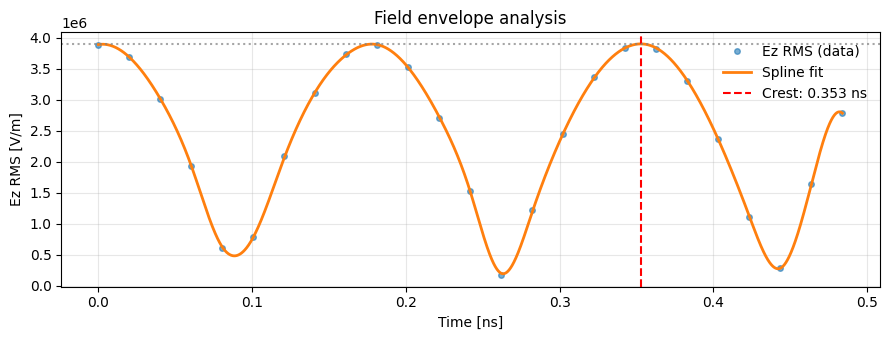

Crest: t = 0.3527 ns | Ez RMS = 3.904e+06 V/m


In [7]:
s_factor = 1e-4 * Ez_rms.var() * Ez_rms.size
spl = UnivariateSpline(t_ns, Ez_rms, s=s_factor)
t_fit = np.linspace(t_ns[0], t_ns[-1], 8000)
Ez_fit = spl(t_fit)

i_crest = int(np.argmax(Ez_fit))
t_crest = t_fit[i_crest]
E_crest = Ez_fit[i_crest]

fig, ax = plt.subplots(figsize=(9, 3.5))
ax.plot(t_ns, Ez_rms, 'o', ms=4, alpha=0.6, label='Ez RMS (data)')
ax.plot(t_fit, Ez_fit, '-', lw=2, label='Spline fit')
ax.axvline(t_crest, ls='--', color='red', lw=1.5, label=f'Crest: {t_crest:.3f} ns')
ax.axhline(E_crest, ls=':', color='gray', alpha=0.7)
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Ez RMS [V/m]')
ax.set_title('Field envelope analysis')
ax.legend(frameon=False, loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Crest: t = {t_crest:.4f} ns | Ez RMS = {E_crest:.3e} V/m")

### Select I/Q snapshots

Choose two snapshots ~90° apart for complex phasor construction.

In [8]:
i0, i90, dt_err, amp_ratio = select_iq_snapshots(t_ns, Ez_rms, F_HZ)

print(f"\nI/Q snapshot selection:")
print(f"  i0={i0:3d}  t={t_ns[i0]:8.4f} ns  Ez_rms={Ez_rms[i0]:.3e} V/m")
print(f"  i90={i90:3d}  t={t_ns[i90]:8.4f} ns  Ez_rms={Ez_rms[i90]:.3e} V/m")
print(f"  Δt = {(t_ns[i90]-t_ns[i0]):.4f} ns (target: {0.25*T_NS:.4f} ns)")
print(f"  Time error: {dt_err*100:.2f}%")
print(f"  Amplitude ratio: {amp_ratio:.3f}")
print(f"\nUsing peak envelope for scaling: {Ez_peak:.3e} V/m")


I/Q snapshot selection:
  i0= 11  t=  0.2217 ns  Ez_rms=2.706e+06 V/m
  i90= 15  t=  0.3024 ns  Ez_rms=2.452e+06 V/m
  Δt = 0.0806 ns (target: 0.0875 ns)
  Time error: 7.89%
  Amplitude ratio: 0.906

Using peak envelope for scaling: 3.893e+06 V/m


## 2. Build axisymmetric field map for RF-Track

Transform solver coordinates to cavity frame:
- r = |x| (mm → m)
- z = y_cathode - y (mm → m, emission in +z)
- Er = sign(x) × Ex
- Ez = Ey

In [9]:
# Solver coordinates
x_mm = xy['vertices'][:, 0]
y_mm = xy['vertices'][:, 1]

# Cavity frame
r_m = np.abs(x_mm) * 1e-3
z_m = (Y_CATHODE_MM - y_mm) * 1e-3

z_min = float(np.min(z_m))
z_max = float(np.max(z_m))

print(f"Cavity extent: z ∈ [{z_min*1e3:.2f}, {z_max*1e3:.2f}] mm")
print(f"               r ∈ [0, {R_MAX_M*1e3:.2f}] mm")

# Raw resolution from solver vertices (after axis re-map)
def _min_pos_diff(vals):
    u = np.unique(vals)
    if u.size < 2:
        return np.nan
    d = np.diff(np.sort(u))
    d = d[d > 0]
    return float(d.min()) if d.size else np.nan

def _median_pos_diff(vals):
    u = np.unique(vals)
    if u.size < 2:
        return np.nan
    d = np.diff(np.sort(u))
    d = d[d > 0]
    return float(np.median(d)) if d.size else np.nan

dr_min = _min_pos_diff(r_m)
dz_min = _min_pos_diff(z_m)
dr_med = _median_pos_diff(r_m)
dz_med = _median_pos_diff(z_m)

nr_unique = np.unique(r_m).size
nz_unique = np.unique(z_m).size

print(f"Raw resolution (from vertices):")
print(f"  Δr_min ≈ {dr_min*1e6:.2f} μm | Δr_med ≈ {dr_med*1e6:.2f} μm | unique r = {nr_unique}")
print(f"  Δz_min ≈ {dz_min*1e6:.2f} μm | Δz_med ≈ {dz_med*1e6:.2f} μm | unique z = {nz_unique}")

# Raw data size and point counts
def _fmt_bytes(n):
    for unit in ["B", "KB", "MB", "GB"]:
        if n < 1024:
            return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} TB"

import os
xy_size = os.path.getsize(XY_FIELDMAP)
yz_size = os.path.getsize(YZ_FIELDMAP)

print(f"Raw data points:")
print(f"  XY vertices = {xy['vertices'].shape[0]:,} | time steps = {xy['time'].size}")
print(f"  YZ vertices = {yz['vertices'].shape[0]:,} | time steps = {yz['time'].size}")
print(f"File sizes:")
print(f"  {XY_FIELDMAP}: {_fmt_bytes(xy_size)}")
print(f"  {YZ_FIELDMAP}: {_fmt_bytes(yz_size)}")

Cavity extent: z ∈ [-30.51, 52.75] mm
               r ∈ [0, 10.00] mm
Raw resolution (from vertices):
  Δr_min ≈ 0.01 μm | Δr_med ≈ 199.78 μm | unique r = 213
  Δz_min ≈ 233.76 μm | Δz_med ≈ 635.00 μm | unique z = 111
Raw data points:
  XY vertices = 44,178 | time steps = 25
  YZ vertices = 56,055 | time steps = 25
File sizes:
  field_maps/XYplanarSensorData.mat: 28.63 MB
  field_maps/YZplanarSensorData.mat: 36.32 MB


### Construct complex phasor from I/Q snapshots

In [10]:
# Extract fields at i0 and i90
Ex_0 = xy['Ex'][:, i0]
Ex_90 = xy['Ex'][:, i90]
Ey_0 = xy['Ey'][:, i0]
Ey_90 = xy['Ey'][:, i90]

# For I/Q phasor construction, use peak instantaneous fields as envelope
Ey_max_0 = np.max(np.abs(Ey_0))
Ey_max_90 = np.max(np.abs(Ey_90))
Ex_max_0 = np.max(np.abs(Ex_0))
Ex_max_90 = np.max(np.abs(Ex_90))

# Use the maximum instantaneous field as the reference amplitude
E_ref = max(Ey_max_0, Ey_max_90)

print(f"\nField amplitude check:")
print(f"  Ez_rms at i0:  {Ez_rms[i0]:.3e} V/m (spatial RMS - not used)")
print(f"  Ez_rms at i90: {Ez_rms[i90]:.3e} V/m (spatial RMS - not used)")
print(f"  |Ey_0| max (instantaneous): {Ey_max_0:.3e} V/m")
print(f"  |Ey_90| max (instantaneous): {Ey_max_90:.3e} V/m")
print(f"  Using reference amplitude: {E_ref:.3e} V/m")

# Build phasors using peak instantaneous fields for normalization
Ex_phasor = build_iq_phasor(Ex_0, Ex_90, Ex_max_0, Ex_max_90, E_ref)
Ey_phasor = build_iq_phasor(Ey_0, Ey_90, Ey_max_0, Ey_max_90, E_ref)

# Axisymmetric components
Er_vertices = np.sign(x_mm) * Ex_phasor
Ez_vertices = Ey_phasor

print(f"\nPhasor amplitude (for RF-Track):")
print(f"  |Er|_max = {np.max(np.abs(Er_vertices)):.3e} V/m")
print(f"  |Ez|_max = {np.max(np.abs(Ez_vertices)):.3e} V/m")
print(f"\nNote: RF-Track receives full complex field maps Er_grid, Ez_grid.")
print(f"      Field evolves as Re{{E_phasor * exp(j*2π*f*t + j*φ)}}.")


Field amplitude check:
  Ez_rms at i0:  2.706e+06 V/m (spatial RMS - not used)
  Ez_rms at i90: 2.452e+06 V/m (spatial RMS - not used)
  |Ey_0| max (instantaneous): 4.769e+07 V/m
  |Ey_90| max (instantaneous): 4.320e+07 V/m
  Using reference amplitude: 4.769e+07 V/m

Phasor amplitude (for RF-Track):
  |Er|_max = 6.744e+07 V/m
  |Ez|_max = 6.744e+07 V/m

Note: RF-Track receives full complex field maps Er_grid, Ez_grid.
      Field evolves as Re{E_phasor * exp(j*2π*f*t + j*φ)}.


### Interpolate to regular (r,z) grid

In [11]:
r_grid = np.linspace(0, R_MAX_M, NR)
z_grid = np.linspace(Z_MIN, Z_MAX, NZ)
z_grid[np.argmin(np.abs(z_grid))] = 0.0
R, Z = np.meshgrid(r_grid, z_grid)

hr = r_grid[1] - r_grid[0]
hz = z_grid[1] - z_grid[0]

pts = np.column_stack([r_m, z_m])

def interp_complex_field(phasor):
    re_lin = griddata(pts, phasor.real, (R, Z), method='linear')
    im_lin = griddata(pts, phasor.imag, (R, Z), method='linear')
    re_nn = griddata(pts, phasor.real, (R, Z), method='nearest')
    im_nn = griddata(pts, phasor.imag, (R, Z), method='nearest')
    re = np.where(np.isfinite(re_lin), re_lin, re_nn)
    im = np.where(np.isfinite(im_lin), im_lin, im_nn)
    return (re + 1j * im).astype(np.complex128)

Er_grid = interp_complex_field(Er_vertices)
Ez_grid = interp_complex_field(Ez_vertices)

iz0 = int(np.where(z_grid == 0.0)[0][0])    
Ez0_phasor_axis = complex(Ez_grid[iz0, 0])   # on-axis phasor at z=0


print(f"Grid: {Er_grid.shape} (Nz × Nr) | Δr = {hr*1e6:.0f} μm | Δz = {hz*1e6:.2f} μm")
print(f"Field amplitudes: |Ez|_max = {np.max(np.abs(Ez_grid)):.2e} V/m | |Er|_max = {np.max(np.abs(Er_grid)):.2e} V/m")
print(f"On-axis: |Ez(r=0)|_max = {np.max(np.abs(Ez_grid[:, 0])):.2e} V/m")

Grid: (2865, 2501) (Nz × Nr) | Δr = 4 μm | Δz = 13.00 μm
Field amplitudes: |Ez|_max = 6.72e+07 V/m | |Er|_max = 5.20e+07 V/m
On-axis: |Ez(r=0)|_max = 3.79e+07 V/m


### Visualize field maps

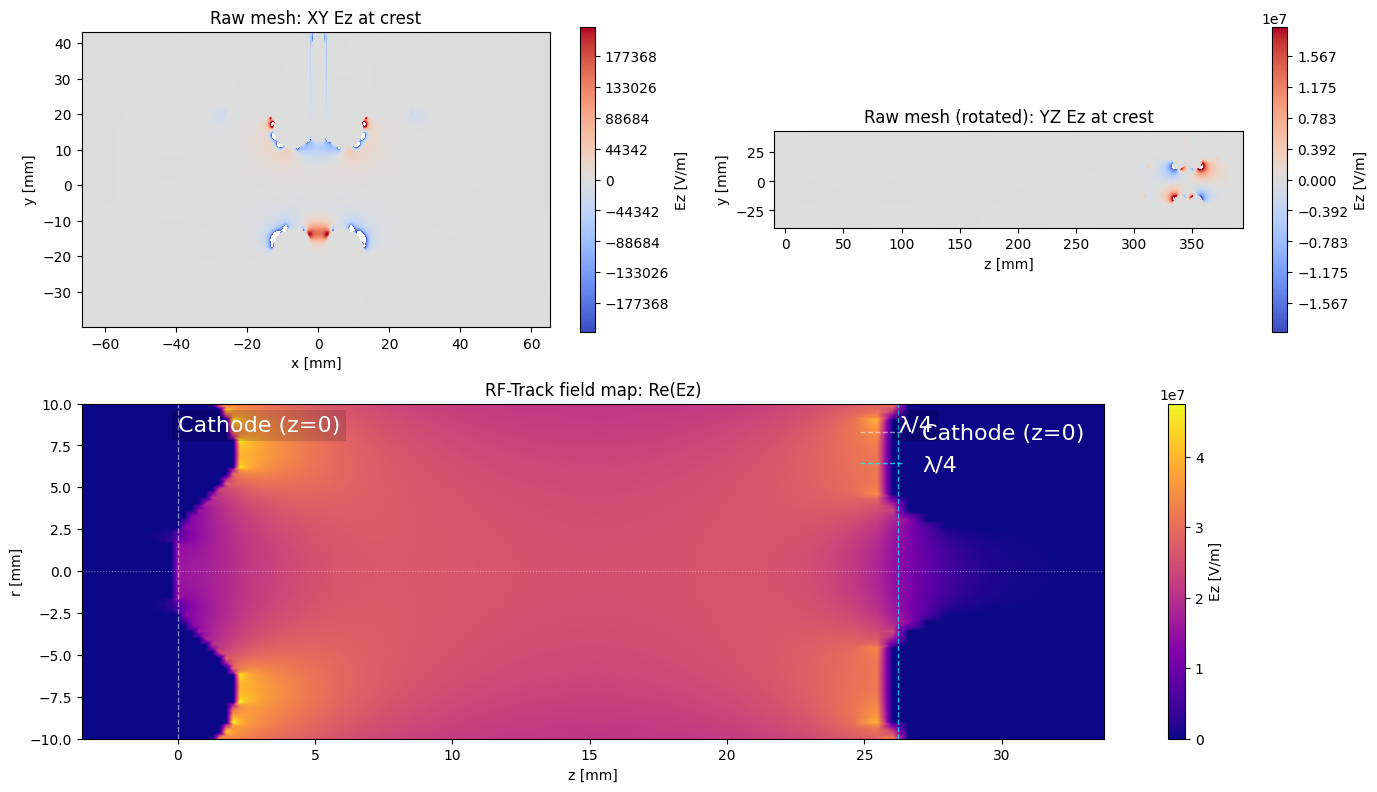

In [12]:
# Raw data field maps (XY and YZ) + RF-Track field map
i_snap = int(np.argmin(np.abs(t_ns - t_crest)))

import matplotlib.tri as mtri
import matplotlib.colors as colors

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.1])

# --- Raw XY map ---
xy_data = xy
verts_xy = xy_data["vertices"]
tri_xy = xy_data["facets"]
Ux = verts_xy[:, 0]
Vy = verts_xy[:, 1]
Fx = np.asarray(xy_data["Ez"])[:, i_snap]

triang_xy = mtri.Triangulation(Ux, Vy, triangles=tri_xy)
ax_xy = fig.add_subplot(gs[0, 0])
p_xy = float(np.percentile(np.abs(Fx), 99)) if Fx.size else 1.0
p_xy = p_xy if p_xy > 0 else 1.0
norm_xy = colors.TwoSlopeNorm(vcenter=0.0, vmin=-p_xy, vmax=p_xy)
levels_xy = np.linspace(-p_xy, p_xy, 257)
cf_xy = ax_xy.tricontourf(triang_xy, Fx, levels=levels_xy, cmap="coolwarm", norm=norm_xy)
ax_xy.set_aspect("equal", adjustable="box")
ax_xy.set_xlabel("x [mm]")
ax_xy.set_ylabel("y [mm]")
ax_xy.set_title("Raw mesh: XY Ez at crest")
plt.colorbar(cf_xy, ax=ax_xy, label="Ez [V/m]")

# --- Raw YZ map (rotated 90°: z on x-axis, y on y-axis) ---
yz_data = yz
verts_yz = yz_data["vertices"]
tri_yz = yz_data["facets"]
Uy = verts_yz[:, 1]
Vz = verts_yz[:, 2]
Fy = np.asarray(yz_data["Ez"])[:, i_snap]

triang_yz = mtri.Triangulation(Vz, Uy, triangles=tri_yz)
ax_yz = fig.add_subplot(gs[0, 1])
p_yz = float(np.percentile(np.abs(Fy), 99)) if Fy.size else 1.0
p_yz = p_yz if p_yz > 0 else 1.0
norm_yz = colors.TwoSlopeNorm(vcenter=0.0, vmin=-p_yz, vmax=p_yz)
levels_yz = np.linspace(-p_yz, p_yz, 257)
cf_yz = ax_yz.tricontourf(triang_yz, Fy, levels=levels_yz, cmap="coolwarm", norm=norm_yz)
ax_yz.set_aspect("equal", adjustable="box")
ax_yz.set_xlabel("z [mm]")
ax_yz.set_ylabel("y [mm]")
ax_yz.set_title("Raw mesh (rotated): YZ Ez at crest")
plt.colorbar(cf_yz, ax=ax_yz, label="Ez [V/m]")

# --- RF-Track field map (mirrored full r range) ---
r_neg = -r_grid[::-1]
r_full = np.concatenate([r_neg, r_grid[1:]])
Ez_full = np.concatenate([Ez_grid[:, ::-1], Ez_grid[:, 1:]], axis=1)

ax_rf = fig.add_subplot(gs[1, :])
extent_full = [z_grid[0]*1e3, z_grid[-1]*1e3, r_full[0]*1e3, r_full[-1]*1e3]
im = ax_rf.imshow(np.real(Ez_full.T), aspect="auto", origin="lower",
                  extent=extent_full, cmap="plasma")
ax_rf.axvline(0, color="white", ls="--", lw=1, alpha=0.5, label="Cathode (z=0)")
ax_rf.axvline(LAMBDA_M/4*1e3, color="cyan", ls="--", lw=1, alpha=0.7, label="λ/4")
ax_rf.axhline(0, color="white", ls=":", lw=0.8, alpha=0.4)
ax_rf.set_xlabel("z [mm]")
ax_rf.set_ylabel("r [mm]")
ax_rf.set_title("RF-Track field map: Re(Ez)")
legend = ax_rf.legend(frameon=False, loc="upper right", fontsize=16)
for text in legend.get_texts():
    text.set_color("white")
ax_rf.text(0, r_full[-1] * 1e3 * 0.93, "Cathode (z=0)", color="white", fontsize=16,
           ha="left", va="top", bbox=dict(facecolor="black", alpha=0.15, edgecolor="none"))
ax_rf.text(LAMBDA_M/4 * 1e3, r_full[-1] * 1e3 * 0.93, "λ/4", color="white", fontsize=16,
           ha="left", va="top", bbox=dict(facecolor="black", alpha=0.15, edgecolor="none"))
plt.colorbar(im, ax=ax_rf, label="Ez [V/m]")

plt.tight_layout()
plt.show()



### On-axis field profile

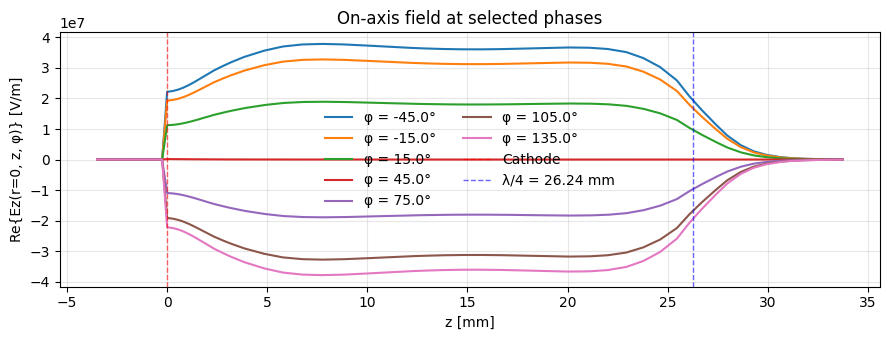

In [13]:
Ez_axis = Ez_grid[:, 0]

phi_opt = -np.angle(Ez_axis[np.argmax(np.abs(Ez_axis))])
offsets_deg = [0, 30, 60, 90, 120, 150, 180]
phases_deg_plot = [np.rad2deg(phi_opt) + d for d in offsets_deg]

fig, ax = plt.subplots(figsize=(9, 3.5))
for deg in phases_deg_plot:
    phi = np.deg2rad(deg)
    Ez_phase = np.real(Ez_axis * np.exp(1j * phi))
    ax.plot(z_grid * 1e3, Ez_phase, lw=1.5, label=f"φ = {deg:.1f}°")

ax.axvline(0, color='red', ls='--', lw=1, alpha=0.6, label='Cathode')
ax.axvline(LAMBDA_M/4 * 1e3, color='blue', ls='--', lw=1, alpha=0.6, label=f'λ/4 = {LAMBDA_M/4*1e3:.2f} mm')
ax.set_xlabel('z [mm]')
ax.set_ylabel('Re{Ez(r=0, z, φ)} [V/m]')
ax.set_title('On-axis field at selected phases')
ax.legend(frameon=False, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Theoretical energy gain

For TM010 electron acceleration:
$$\Delta W(\phi) = -e \int \text{Re}\{\hat{E}_z(0,z) e^{j\phi}\} dz$$

In [14]:
V_peak = np.trapezoid(np.abs(Ez_axis), z_grid)
dW_peak_MeV = V_peak / 1e6

print(f"Accelerating voltage: V_peak ≈ {V_peak/1e6:.3f} MV")
print(f"Maximum energy gain: ΔW_max ≈ {dW_peak_MeV:.3f} MeV\n")

print("Phase scan (theory):")
for deg in PHASE_SCAN_DEG:
    phi = np.deg2rad(deg)
    dW = theoretical_energy_gain(Ez_axis, z_grid, phi)
    print(f"  φ = {deg:6.2f}°  →  ΔW = {dW:7.4f} MeV")

Accelerating voltage: V_peak ≈ 0.937 MV
Maximum energy gain: ΔW_max ≈ 0.937 MeV

Phase scan (theory):
  φ = -90.00°  →  ΔW = -0.6625 MeV
  φ = -86.33°  →  ΔW = -0.7036 MeV
  φ = -82.65°  →  ΔW = -0.7418 MeV
  φ = -78.98°  →  ΔW = -0.7770 MeV
  φ = -75.31°  →  ΔW = -0.8090 MeV
  φ = -71.63°  →  ΔW = -0.8376 MeV
  φ = -67.96°  →  ΔW = -0.8628 MeV
  φ = -64.29°  →  ΔW = -0.8845 MeV
  φ = -60.61°  →  ΔW = -0.9025 MeV
  φ = -56.94°  →  ΔW = -0.9168 MeV
  φ = -53.27°  →  ΔW = -0.9274 MeV
  φ = -49.59°  →  ΔW = -0.9341 MeV
  φ = -45.92°  →  ΔW = -0.9370 MeV
  φ = -42.24°  →  ΔW = -0.9361 MeV
  φ = -38.57°  →  ΔW = -0.9313 MeV
  φ = -34.90°  →  ΔW = -0.9226 MeV
  φ = -31.22°  →  ΔW = -0.9102 MeV
  φ = -27.55°  →  ΔW = -0.8941 MeV
  φ = -23.88°  →  ΔW = -0.8742 MeV
  φ = -20.20°  →  ΔW = -0.8508 MeV
  φ = -16.53°  →  ΔW = -0.8239 MeV
  φ = -12.86°  →  ΔW = -0.7936 MeV
  φ =  -9.18°  →  ΔW = -0.7600 MeV
  φ =  -5.51°  →  ΔW = -0.7234 MeV
  φ =  -1.84°  →  ΔW = -0.6837 MeV
  φ =   1.84°  →  ΔW = 

## 4. RF-Track simulation

1. **Fast phase scan** (very few particles): on-axis launch, no thermal px/py and no transverse offsets.
   This is only to verify that the final kinetic energy follows the expected phase dependence.

2. **One transport run** at a chosen cavity phase (`TRANSPORT_PHASE_DEG`, default 0°) with a *thermionic* launch model:
   - transverse positions on the cathode (uniform disk),
   - transverse thermal momenta (`px,py`),
   - longitudinal emission times `t0` based on Richardson–Dushman current (with Schottky lowering using the normal extraction field at z=0).

In [15]:
# Volume integration / tracking parameters
CATHODE_RADIUS_MM = 1.0          # [mm] emitting radius (adjust to your cathode)
PZ0_MEV_C = 1e-3                 # [MeV/c] ~ 1 eV/c initial longitudinal momentum
Q_FAST_C = 1e-12                 # [C] used for the fast scan (space charge disabled)

vol_params = VolumeBuildParams(
    f_hz=F_HZ,
    map_z0_m=Z_MIN,
    z_min_m=Z_MIN,
    z_max_m=Z_MAX,
    hr_m=DR_UM * 1e-6,
    hz_m=DZ_UM * 1e-6,
    dt_mm=0.5,                   # [mm/c] integration step for Volume tracking
    ode_algorithm="rk2",
    aperture_m=R_MAX_M,
)


Fast phase scan (on-axis, no thermal px/py, small number of particles):


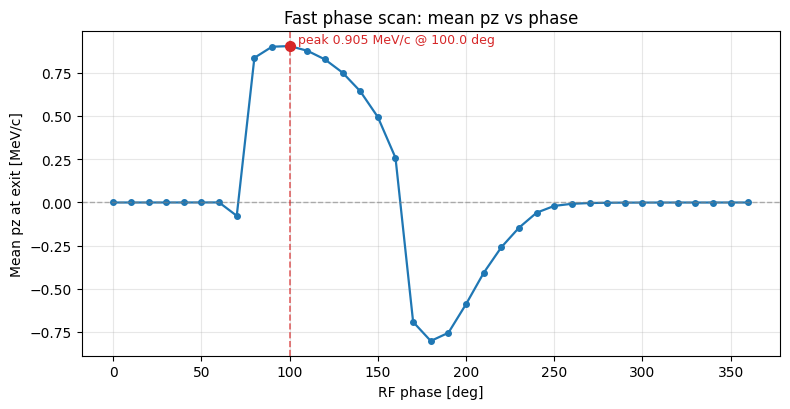

In [16]:
# Fast phase scan
print("Fast phase scan (on-axis, no thermal px/py, small number of particles):")
phase_scan = []
for phi in PHASE_SCAN_PHASES_DEG:
    V = build_volume(rft, Er_grid, Ez_grid, phi, vol_params)
    B0 = build_bunch_simple(rft, PHASE_SCAN_N_PART, CATHODE_RADIUS_MM, PZ0_MEV_C, Q_FAST_C)
    Bout = V.track(B0)
    Mf = Bout.get_phase_space()
    if Mf.shape[0] == 0:
        phase_scan.append((float(phi), np.nan, 0))
        continue
    pz = Mf[:, 5]  # [MeV/c] in RF-Track phase space
    phase_scan.append((float(phi), float(np.mean(pz)), int(Mf.shape[0])))

phase_scan = np.array(phase_scan, dtype=float)

# Plot mean pz vs phase
phi_deg = phase_scan[:, 0]
pz_mean = phase_scan[:, 1]
mask = np.isfinite(pz_mean)

fig, ax = plt.subplots(figsize=(8, 4.2))
ax.plot(phi_deg[mask], pz_mean[mask], 'o-', ms=4, lw=1.6, color='tab:blue')
ax.axhline(0.0, color='gray', ls='--', lw=1.0, alpha=0.6)
if np.any(mask):
    i_max = int(np.nanargmax(pz_mean))
    ax.axvline(phi_deg[i_max], color='tab:red', ls='--', lw=1.2, alpha=0.7)
    ax.plot(phi_deg[i_max], pz_mean[i_max], 'o', ms=7, color='tab:red', zorder=5)
    ax.text(
        phi_deg[i_max], pz_mean[i_max],
        f"  peak {pz_mean[i_max]:.3f} MeV/c @ {phi_deg[i_max]:.1f} deg",
        va='bottom', ha='left', fontsize=9, color='tab:red'
    )
ax.set_xlabel('RF phase [deg]')
ax.set_ylabel('Mean pz at exit [MeV/c]')
ax.set_title('Fast phase scan: mean pz vs phase')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
# --- (2) Thermionic transport at fixed phase ----------------------------

print(f"Transport run at φ = {TRANSPORT_PHASE_DEG:.1f}° with thermionic launch:")

B0, info = build_bunch_thermionic(
    rft,
    int(TRANSPORT_N_PART),
    float(TRANSPORT_PHASE_DEG),
    cathode_radius_mm=R_CATHODE_MM,
    cathode_T_K=T_CATHODE_K,
    work_function_eV=PHI_EFF_EV,
    beta_field=BETA_F,
    Q_target_C=Q_TARGET_PC * 1e-12,
    pz0_MeV_c=PZ_INIT_MEVC,
    Ez0_phasor_axis=Ez0_phasor_axis,
)

print(f"  Ez0(φ)  = {info['Ez0']:.3e} V/m (on-axis @ z≈0)")
print(f"  J       = {info['J_Apm2']:.3e} A/m^2   (Richardson + Schottky)")
print(f"  I       = {info['I_A']:.3e} A        (× cathode area)")
print(f"  τ_emit  = {info['tau_ns']:.3f} ns     for Q = {Q_TARGET_PC:.1f} pC")

# Diagnostics planes
z_snaps = np.linspace(0.0, float(z_max), N_Z_SNAP + 1)[1:]     # [m]

# Single track with screens for snapshots
print(f"Tracking once with {len(z_snaps)} screens...")
Bout, snaps = track_volume_with_screens(
    rft,
    Er_grid,
    Ez_grid,
    float(TRANSPORT_PHASE_DEG),
    vol_params,
    B0,
    z_snaps,
)
print("Tracking complete.")

M_snaps = []
if snaps:
    for snap in snaps:
        M = snap.get_phase_space('%X %Px %Y %Py %Z %Pz', 'good')
        M_snaps.append(np.array(M, copy=True))
else:
    M_snaps = [np.array(Bout.get_phase_space('%X %Px %Y %Py %Z %Pz', 'good'), copy=True)] * len(z_snaps)

# Final phase space
Mf_f = np.array(Bout.get_phase_space('%X %Px %Y %Py %Z %Pz', 'good'), copy=True)

# Simple transport-style summary from stored snapshots
tt = []
for z_m, M in zip(z_snaps, M_snaps):
    if M.shape[0] == 0:
        tt.append([z_m, np.nan, np.nan, np.nan, np.nan, 0.0])
        continue
    tt.append([
        float(z_m),
        float(np.std(M[:, 0])),                                   # σx [mm]
        float(np.std(M[:, 2])),                                   # σy [mm]
        float(np.mean(M[:, 5])),                                  # <Pz> [MeV/c]
        float(np.mean(kinetic_energy(M[:, 1], M[:, 3], M[:, 5]))),# <Ek> [MeV]
        float(M.shape[0]),
    ])
tt = np.asarray(tt)

Transport run at φ = 100.0° with thermionic launch:
  Ez0(φ)  = -1.809e+07 V/m (on-axis @ z≈0)
  J       = 4.618e+05 A/m^2   (Richardson + Schottky)
  I       = 3.576e+00 A        (× cathode area)
  τ_emit  = 0.014 ns     for Q = 50.0 pC
Tracking once with 10 screens...
Tracking complete.


## 5. Analysis and visualization


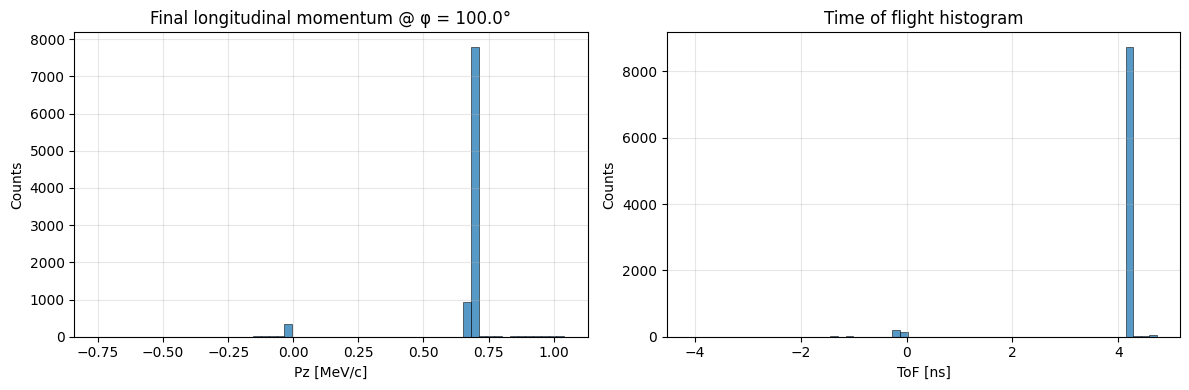

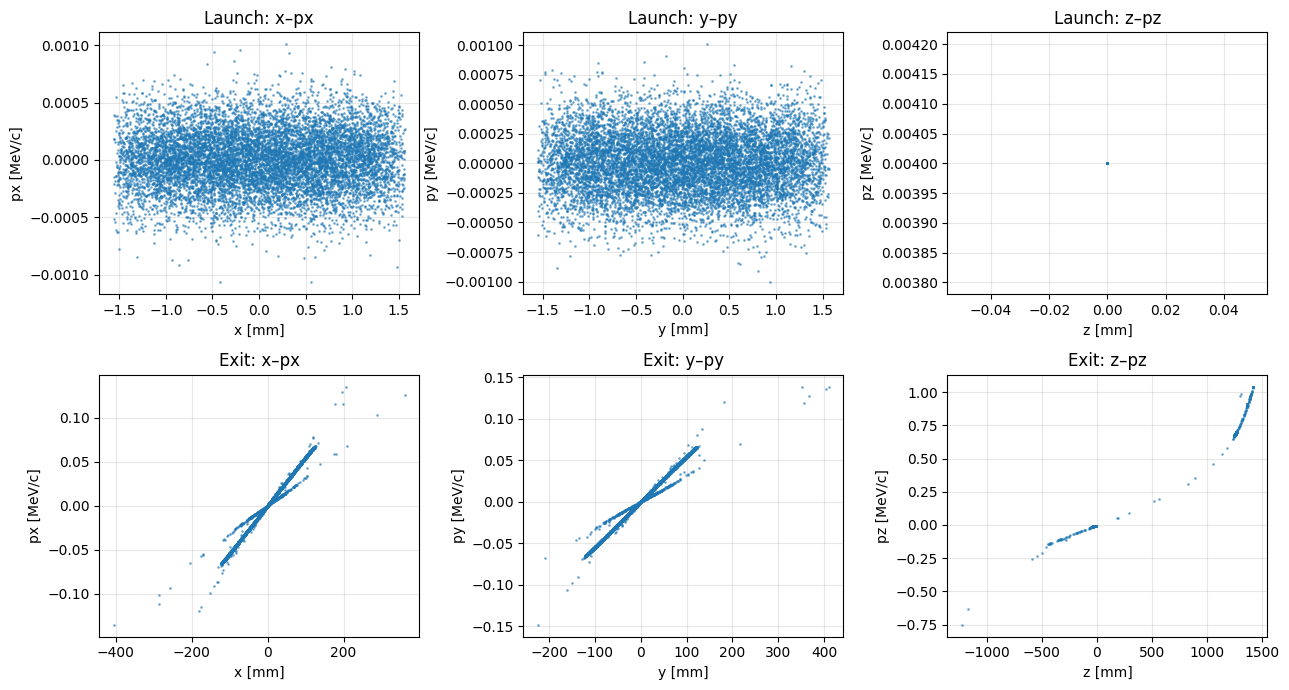

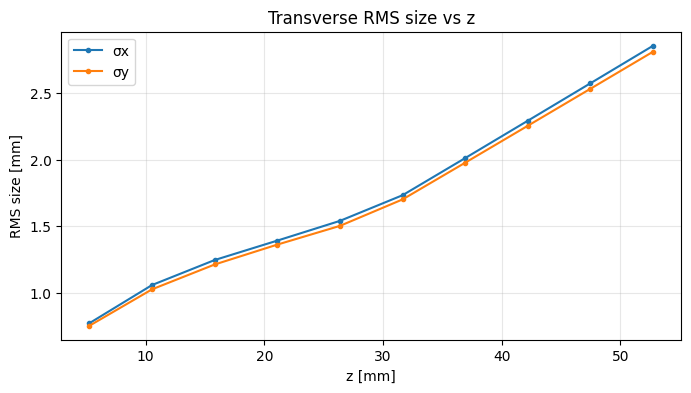

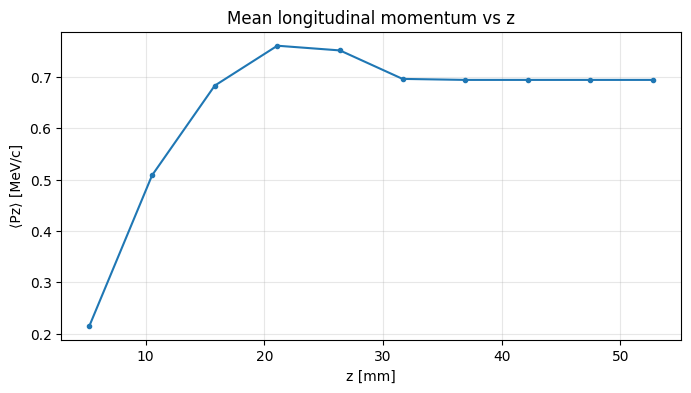

In [18]:
# -------------------- Diagnostics: spectra + phase space + evolution --------------------

# ---- Final spectra: pz + ToF (from z position) ---------------------------
if Mf_f.shape[0] > 0:
    # pz [MeV/c]
    pz_f = Mf_f[:, 5]

    # ToF estimate from final z position: t = z / c
    tof_ns = (Mf_f[:, 4] * 1e-3 / c) * 1e9
    tof_ns = tof_ns[np.isfinite(tof_ns)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(pz_f, bins=60, alpha=0.75, edgecolor='black', lw=0.5)
    axes[0].set_xlabel('Pz [MeV/c]')
    axes[0].set_ylabel('Counts')
    axes[0].grid(alpha=0.3)
    axes[0].set_title(f'Final longitudinal momentum @ φ = {TRANSPORT_PHASE_DEG:.1f}°')

    if tof_ns is not None and len(tof_ns) > 0:
        axes[1].hist(tof_ns, bins=60, alpha=0.75, edgecolor='black', lw=0.5)
        axes[1].set_xlabel('ToF [ns]')
        axes[1].set_ylabel('Counts')
        axes[1].grid(alpha=0.3)
        axes[1].set_title('Time of flight histogram')
    else:
        axes[1].axis("off")
        axes[1].text(0.5, 0.5, "ToF not available", ha="center", va="center")

    plt.tight_layout()
    plt.show()

# ---- Phase space: "launch" vs exit --------------------------------------
Mf_launch = B0.get_phase_space('%X %Px %Y %Py %Z %Pz', 'good')

if Mf_f.shape[0] > 0 and Mf_launch.shape[0] > 0:
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))

    axes[0, 0].plot(Mf_launch[:, 0], Mf_launch[:, 1], '.', ms=2, alpha=0.5)
    axes[0, 0].set_xlabel('x [mm]'); axes[0, 0].set_ylabel('px [MeV/c]')
    axes[0, 0].set_title('Launch: x–px'); axes[0, 0].grid(alpha=0.3)

    axes[0, 1].plot(Mf_launch[:, 2], Mf_launch[:, 3], '.', ms=2, alpha=0.5)
    axes[0, 1].set_xlabel('y [mm]'); axes[0, 1].set_ylabel('py [MeV/c]')
    axes[0, 1].set_title('Launch: y–py'); axes[0, 1].grid(alpha=0.3)

    axes[0, 2].plot(Mf_launch[:, 4], Mf_launch[:, 5], '.', ms=2, alpha=0.5)
    axes[0, 2].set_xlabel('z [mm]'); axes[0, 2].set_ylabel('pz [MeV/c]')
    axes[0, 2].set_title('Launch: z–pz'); axes[0, 2].grid(alpha=0.3)

    axes[1, 0].plot(Mf_f[:, 0], Mf_f[:, 1], '.', ms=2, alpha=0.5)
    axes[1, 0].set_xlabel('x [mm]'); axes[1, 0].set_ylabel('px [MeV/c]')
    axes[1, 0].set_title('Exit: x–px'); axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(Mf_f[:, 2], Mf_f[:, 3], '.', ms=2, alpha=0.5)
    axes[1, 1].set_xlabel('y [mm]'); axes[1, 1].set_ylabel('py [MeV/c]')
    axes[1, 1].set_title('Exit: y–py'); axes[1, 1].grid(alpha=0.3)

    axes[1, 2].plot(Mf_f[:, 4], Mf_f[:, 5], '.', ms=2, alpha=0.5)
    axes[1, 2].set_xlabel('z [mm]'); axes[1, 2].set_ylabel('pz [MeV/c]')
    axes[1, 2].set_title('Exit: z–pz'); axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# ---- Phase-space evolution vs z: RMS sizes + <Pz> ------------------------
if len(M_snaps) and len(z_snaps) == len(M_snaps):
    z_mm = 1e3 * np.asarray(z_snaps)  # [mm]

    sig_x = np.array([np.std(M[:, 0]) if M.shape[0] else np.nan for M in M_snaps])  # [mm]
    sig_y = np.array([np.std(M[:, 2]) if M.shape[0] else np.nan for M in M_snaps])  # [mm]
    pz_m  = np.array([np.mean(M[:, 5]) if M.shape[0] else np.nan for M in M_snaps])  # [MeV/c]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(z_mm, sig_x, 'o-', ms=3, label='σx')
    ax.plot(z_mm, sig_y, 'o-', ms=3, label='σy')
    ax.set_xlabel('z [mm]')
    ax.set_ylabel('RMS size [mm]')
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_title('Transverse RMS size vs z')
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(z_mm, pz_m, 'o-', ms=3)
    ax.set_xlabel('z [mm]')
    ax.set_ylabel('⟨Pz⟩ [MeV/c]')
    ax.grid(alpha=0.3)
    ax.set_title('Mean longitudinal momentum vs z')
    plt.show()
else:
    print("No snapshots available (M_snaps empty or z_snaps mismatch).")

